# Assignment 2: Naive Bayes and Text Classification

Only use the already imported library `numpy`. Make sure that the `liar.txt` dataset is in the same directory as the notebook.

List your team members (name and immatriculation number) in the following cell:

* Adityakrishna Okade (3507212), M.Sc.Infotech
* Simhadri Holagundhi (3508282), M.Sc.Infotech

In [1]:
# Load required packages and dataset. Do not modify.
import numpy as np


def load_liar_dataset():
    import string
    
    with open('liar.txt', mode='r', encoding='utf-8') as f:
        rows = [l.strip().split('\t')[:2] for l in f]
    
    y, X = zip(*rows)
    X = [x.translate(str.maketrans('', '', string.punctuation)).lower().split() for x in X]
    
    return X, y
    

X, y = load_liar_dataset()
y = np.array(list(y))
print('Sample:')
print(f'{y[0]}: {X[0]}')
print(f'{y[5]}: {X[5]}')

Sample:
real: ['thanks', 'to', 'our', 'reforms', 'the', 'average', 'family', 'will', 'have', 'an', 'extra', '322', 'to', 'spend']
real: ['weve', 'won', 'twice', 'as', 'many', 'states', 'weve', 'won', 'a', 'greater', 'share', 'of', 'the', 'popular', 'vote']


## Task 2: Fake News Classification with Naive Bayes

Implement a Naive Bayes classifier with Laplace smoothing to detect whether a text message is fake or real (not fake).

A text message is represented by a list of string tokens as shown above.
The classification target is binary and the two possible labels are the strings `'fake'` and `'real'`.

Fill out the methods in `NaiveBayesFakeNewsClassifier` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed.

Hint: Try to map the text messages to word frequency vectors by counting how often each word occurs in a message.

In [2]:
class NaiveBayesFakeNewsClassifier(object):
    def __init__(self):
        self.prob_word_real = None
        self.prob_word_fake = None
        self.priors = {}
    
    def fit(self, X, y):
        """
        X is a list of `n` text messages. Each text message is a list of strings with at least length one.
        y is a list of `n` labels either the string 'fake' or the string 'real'.
        """
        self.vocabulary = list(set([word for msg in X for word in msg]))
        
        vocab_len = len(self.vocabulary)

        word_counts_per_msg = {unique_word: [0] * len(X) for unique_word in self.vocabulary}

        for index, msg in enumerate(X):
            for word in msg:
                word_counts_per_msg[word][index] += 1


        datafr = np.array(list(word_counts_per_msg.values())).T
        real_index = [i  for i, o in enumerate(y) if o == 'real']
        fake_index = [i for i, o in enumerate(y) if o == 'fake']

        word_count_real = datafr[real_index, : ]
        word_count_fake = datafr[fake_index, : ]

        sum_real = np.sum(word_count_real, axis = 0)
        sum_fake = np.sum(word_count_fake, axis = 0)

        self.sum_real_total = np.sum(sum_real)
        self.sum_fake_total = np.sum(sum_fake)

        self.prob_word_real = np.divide(sum_real + 1, self.sum_real_total +  vocab_len) 
        self.prob_word_fake = np.divide(sum_fake + 1, self.sum_fake_total +  vocab_len) 

        self.priors['real'] = len(real_index) * 1.0 / y.shape[0]
        self.priors['fake'] = len(fake_index) * 1.0 / y.shape[0]
    
    def predict(self, X):
        """
        X is a list of `n` text messages. Each text message is a list of strings with at least length one.
        The method returns a list of `n` strings, i.e. classification labels ('fake' or 'real').
        """
        y_pred = []
        for x in X:
            prob_real_word = 0.0
            prob_fake_word = 0.0
            for w in x:
                try:
                    index = self.vocabulary.index(w)
                    prob_real_word += np.log(self.prob_word_real[index])
                    prob_fake_word += np.log(self.prob_word_fake[index])
                except:
                    prob_real_word += 1.0 / (self.sum_real_total + len(self.vocabulary))
                    prob_fake_word += 1.0 / (self.sum_fake_total + len(self.vocabulary))
            prob_real_word += np.log(self.priors['real'])
            prob_fake_word += np.log(self.priors['fake'])
        
            y_pred.append('real' if prob_real_word > prob_fake_word else 'fake' )
        y_pred = np.array(y_pred)

        return y_pred

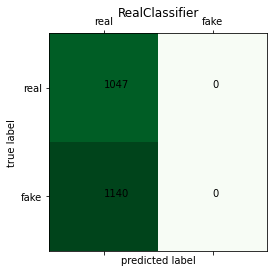

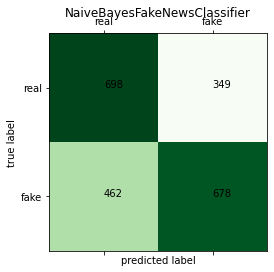

In [6]:
# The following code will evaluate your classifier.
class RealClassifier(object):
    """
    This classifier is a primitive baseline, which just predicts the most common class each time.
    Naive Bayes should definitely beat this.
    """
    def fit(self, X, y): pass
    def predict(self, X): return len(X)*['real']

    
def train_evaluate(classifier, X, y):
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import train_test_split
    
    # Apply train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
    # Inititialize and train classifier.
    classifier.fit(X_train, y_train)
    # Evaluate classifier on test data.
    yhat_test = classifier.predict(X_test)
    cmatrix = confusion_matrix(y_test, yhat_test, labels=['real', 'fake'])
    
    return cmatrix


def plot_confusion_matrix(cmatrix, classifier_name):
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(1, 1)
    ax.matshow(cmatrix, cmap='Greens')
    for x in (0, 1):
        for y in (0, 1):
            ax.text(x, y, cmatrix[y, x])
    ax.set_xlabel('predicted label')
    ax.set_ylabel('true label')
    ax.set_xticklabels(['', 'real', 'fake'])
    ax.set_yticklabels(['', 'real', 'fake'])
    ax.set_title(classifier_name)

    
    
real_classifier = RealClassifier()
your_classifier = NaiveBayesFakeNewsClassifier()
real_cmatrix = train_evaluate(real_classifier, X, y)
your_cmatrix = train_evaluate(your_classifier, X, y)

plot_confusion_matrix(real_cmatrix, 'RealClassifier')
plot_confusion_matrix(your_cmatrix, 'NaiveBayesFakeNewsClassifier')